In [1]:
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

using project root as working dir


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

using cuda device


In [ ]:
import numpy as np
from datetime import datetime
import seaborn as sns
import pandas as pd

from src.evaluator import Evaluator
from src.args import gridsearch_args

experiment = dict(
    key=datetime.now().strftime("%d-%m--%H-%M"),
    reps=3,
    args=gridsearch_args()
)
result = []
compression_opts = dict(method='zip', archive_name=f"{experiment['key']}.zip")

run_len = len(experiment['args']) * experiment['reps']
for i, args in enumerate(experiment["args"]):
    res = {
        "loss": [],
        "ap": [],
        "f1": []
    }
    for rep in range(experiment["reps"]):
        print(f"running evaluator {i * experiment['reps'] + rep}/{run_len}")
        evaluator = Evaluator(
            args=args,
            writer_log_dir=f"new_runs/{experiment['key']}/s{args.epoch_graph_size}-a{args.epoch_graph_alpha}-b{args.epoch_graph_boredom_pth}-l{args.layers}xs{args.layer_size}--{rep}",
            device=device
        )
        evaluator.train(
            optimizer=torch.optim.Adam(evaluator.net.parameters(), lr=1e-3),
            save_fig=False
        )
        test_loss, test_ap, test_f1 = evaluator.test(
            epoch=args.epochs,
            save_fig=False
        )
        res["loss"].append(test_loss)
        res["ap"].append(test_ap)
        res["f1"].append(test_f1)

    result.append({
        "i": i,
        "args": args,
        "res": res,
    })
    # save results just in case the run fails
    result_df = pd.DataFrame(result)
    result_df.to_csv(f"{experiment['key']}.csv", index=False, compression=compression_opts)

In [6]:
# print result
sorted_result = sorted(result, key=lambda item: np.mean(item["res"]["ap"]))
print(*[ (item["args"].epoch_graph_size, item["args"].epoch_graph_alpha, np.mean(item["res"]["ap"])) for item in sorted_result ], sep='\n')

(50, 1.0, 0.21121187011400858)
(50, 0.75, 0.6296031524737676)
(100, 0.25, 0.6472020894289017)
(50, 0, 0.6675135418772697)
(50, 0.5, 0.8772737185160319)
(250, 0.75, 0.8815923929214478)
(100, 1.0, 0.8941956758499146)
(100, 0.75, 0.9069155851999918)
(250, 1.0, 0.9399912556012472)
(50, 0.25, 0.947341243426005)
(250, 0.5, 0.9643312493960062)
(100, 0.5, 0.9643507997194926)
(250, 0.25, 0.9712391893068949)
(100, 0, 0.9872907400131226)
(250, 0, 0.9881699482599894)


In [7]:
compression_opts = dict(method='zip', archive_name=f"{experiment['key']}.csv")
result_df = pd.DataFrame(result)
result_df.to_csv(f"{experiment['key']}.csv", index=False, compression=compression_opts)

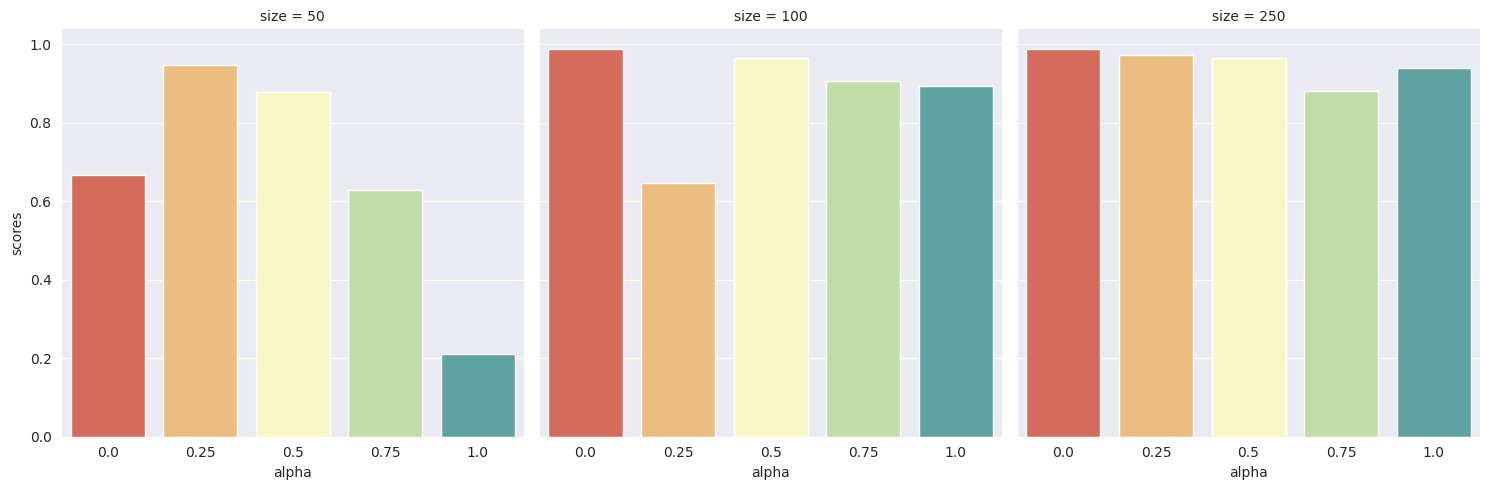

In [17]:
data = pd.DataFrame({
    "size": [r["args"].epoch_graph_size for r in result],
    "alpha": [r["args"].epoch_graph_alpha for r in result],
    "scores": [np.mean(r["res"]["ap"]) for r in result],
})

sns.catplot(
    data=data,
    col="size",
    x="alpha",
    y="scores",
    palette="Spectral",
    kind = "bar"
)

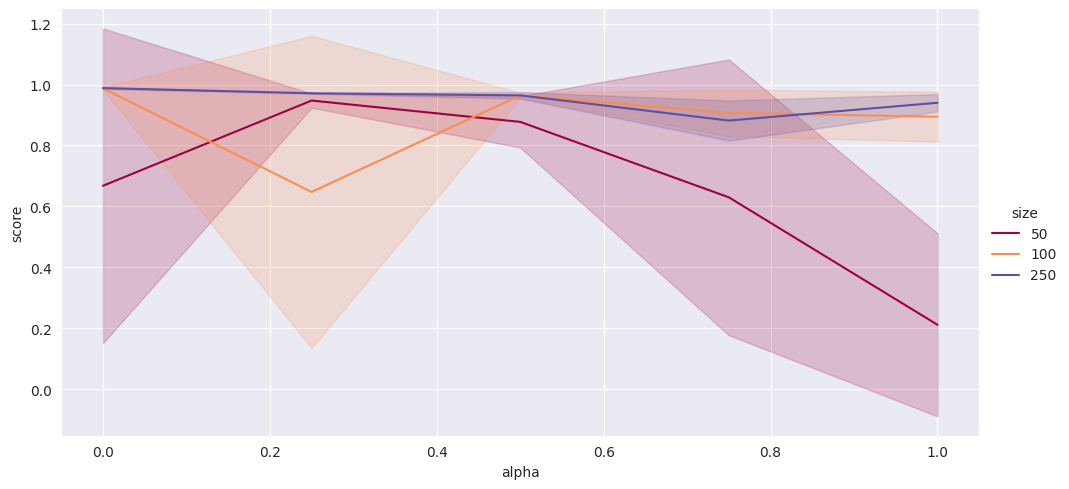

In [31]:
results = [
    {
        "size": r["args"].epoch_graph_size,
        "alpha": r["args"].epoch_graph_alpha,
        "score": score
    }
    for r in result
    for score in r["res"]["ap"]
]

data = pd.DataFrame({
    "size": [r["size"] for r in results],
    "alpha": [r["alpha"] for r in results],
    "score": [r["score"] for r in results],
})

sns.relplot(
    data=data, kind="line",
    hue="size",
    x="alpha",
    y="score",
    errorbar="sd",
    palette="Spectral",
    aspect=2,
)